In [14]:
import logging

# ログ設定
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [49]:
import MeCab
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def preprocess_and_cluster(noun_vectors, num_clusters):
    """
    データの前処理（標準化、次元削減）を行い、K-meansクラスタリングを実行する。
    """
    # データの標準化
    scaler = StandardScaler()
    scaled_vectors = scaler.fit_transform(noun_vectors)

    # 次元削減（例: PCAで2次元に削減）
    pca = PCA(n_components=10)  # 次元削減後の次元数を設定
    reduced_vectors = pca.fit_transform(scaled_vectors)

    # K-meansクラスタリングの実行
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(reduced_vectors)

    return kmeans, reduced_vectors

def process_noun_batch(model, nouns, num_clusters):
    """
    バッチ内の名詞に対してクラスタリングを実行し、結果を返す。
    """
    # 名詞のベクトルを取得
    noun_vectors = np.array([model[word] for word in nouns])

    if noun_vectors.size == 0:
        print("名詞ベクトルが空です。")
        return None, None, None, {}

    # K-meansクラスタリングの実行
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(noun_vectors)

    # 各名詞が属するクラスタを取得
    cluster_indices = kmeans.labels_

    # 名詞とクラスタの対応を取得
    noun_cluster_map = {noun: cluster_indices[i] for i, noun in enumerate(nouns)}

    # 結果を表示 (例: 最初の10名詞)
    for noun, cluster in list(noun_cluster_map.items())[:10]:
        print(f"Noun: {noun}, Cluster: {cluster}")

    return noun_vectors, kmeans, cluster_indices, noun_cluster_map


def kmeans_cluster_nouns_with_preprocessing(model_path, num_clusters, batch_size):
    """
    名詞をバッチごとに処理し、前処理を行った後にK-meansクラスタリングを実行する。
    """
    # Word2Vecモデルの読み込み
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # MeCabの初期化
    mecab = MeCab.Tagger('-r /opt/homebrew/etc/mecabrc -d /opt/homebrew/lib/mecab/dic/ipadic')

    # 名詞を格納するリスト
    nouns = []

    # バッチごとの結果を格納するリスト
    all_noun_vectors = []
    all_cluster_indices = []
    all_noun_cluster_map = {}  # クラスタごとの名詞を格納するマップ

    # モデル内の単語を1つずつ解析
    for idx, word in enumerate(model.index_to_key):
        parsed = mecab.parse(word)
        for line in parsed.splitlines():
            if line == 'EOS':  # MeCabの解析終了マーク
                break
            fields = line.split('\t')
            if len(fields) > 1:
                pos_info = fields[1].split(',')  # 品詞情報を取得
                if pos_info[0] == '名詞' and pos_info[1] == '一般':  # 一般名詞の条件を追加
                    nouns.append(word)
                    break

        # バッチサイズに到達したら処理
        if len(nouns) >= batch_size:
            print(f"Processing batch {idx // batch_size + 1}...")  # バッチ進行状況の表示
            noun_vectors, kmeans, cluster_indices, noun_cluster_map = process_noun_batch(model, nouns, num_clusters)
            if noun_vectors is not None:
                all_noun_vectors.append(noun_vectors)
                all_cluster_indices.append(cluster_indices)
                for noun, cluster in noun_cluster_map.items():
                    if cluster not in all_noun_cluster_map:
                        all_noun_cluster_map[cluster] = []
                    all_noun_cluster_map[cluster].append(noun)
            nouns.clear()  # 次のバッチのためにリストをクリア

    # 最後に残った名詞を処理（バッチに満たない場合）
    if nouns:
        print("Processing final batch...")
        noun_vectors, kmeans, cluster_indices, noun_cluster_map = process_noun_batch(model, nouns, num_clusters)
        if noun_vectors is not None:
            all_noun_vectors.append(noun_vectors)
            all_cluster_indices.append(cluster_indices)
            for noun, cluster in noun_cluster_map.items():
                if cluster not in all_noun_cluster_map:
                    all_noun_cluster_map[cluster] = []
                all_noun_cluster_map[cluster].append(noun)

    # 結果を連結して最終結果とする
    if all_noun_vectors:
        all_noun_vectors = np.vstack(all_noun_vectors)
        all_cluster_indices = np.concatenate(all_cluster_indices)
        print(f"Total vectors: {all_noun_vectors.shape}")

        # データの前処理とクラスタリング
        kmeans, reduced_vectors = preprocess_and_cluster(all_noun_vectors, num_clusters)

        # クラスタごとのサンプリングと表示
        print("----- クラスタごとのサンプリング結果 -----")
        for cluster, nouns_in_cluster in all_noun_cluster_map.items():
            print(f"\nCluster {cluster}:")
            sampled_nouns = random.sample(nouns_in_cluster, min(100, len(nouns_in_cluster)))  # 最大100個をサンプリング
            for noun in sampled_nouns:
                print(f"  {noun}")

    else:
        all_noun_vectors = None

    return all_noun_vectors, kmeans, all_cluster_indices


In [50]:

model_path = '../data/japanese_word2vec_vectors.vec'  # モデルのパスを指定
num_clusters = 600  # クラスタ数を指定
batch_size = 1000  # バッチサイズを指定

noun_vectors, kmeans, cluster_indices = kmeans_cluster_nouns_with_preprocessing(model_path, num_clusters, batch_size)

2024-09-16 03:56:30,234 - INFO - loading projection weights from ../data/japanese_word2vec_vectors.vec
2024-09-16 03:57:59,829 - INFO - KeyedVectors lifecycle event {'msg': 'loaded (1015474, 200) matrix of type float32 from ../data/japanese_word2vec_vectors.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-09-16T03:57:59.829590', 'gensim': '4.3.3', 'python': '3.9.6 (default, Mar 29 2024, 10:51:09) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


Processing batch 3...
Noun: もの, Cluster: 134
Noun: 中, Cluster: 205
Noun: 者, Cluster: 412
Noun: 時, Cluster: 93
Noun: 名, Cluster: 460
Noun: ば, Cluster: 214
Noun: 間, Cluster: 281
Noun: 上, Cluster: 68
Noun: 内, Cluster: 242
Noun: 他, Cluster: 83
Processing batch 5...
Noun: 南西, Cluster: 498
Noun: [鉄道], Cluster: 33
Noun: 墓, Cluster: 311
Noun: 隣, Cluster: 106
Noun: ざる, Cluster: 93
Noun: 中央部, Cluster: 505
Noun: 質, Cluster: 597
Noun: 信号, Cluster: 415
Noun: 同時, Cluster: 440
Noun: 政治的, Cluster: 219
Processing batch 8...
Noun: [文化_(元号)], Cluster: 53
Noun: [東日本大震災], Cluster: 410
Noun: 責任者, Cluster: 351
Noun: フィート, Cluster: 107
Noun: 濃度, Cluster: 244
Noun: 背後, Cluster: 252
Noun: 職務, Cluster: 241
Noun: 山地, Cluster: 46
Noun: [競馬の競走], Cluster: 126
Noun: 電源, Cluster: 496
Processing batch 10...
Noun: 負, Cluster: 5
Noun: [6月1日], Cluster: 8
Noun: ラン, Cluster: 188
Noun: 平坦, Cluster: 27
Noun: ラスト, Cluster: 597
Noun: 荷物, Cluster: 407
Noun: 痕跡, Cluster: 551
Noun: レッド, Cluster: 188
Noun: [千葉ロッテマリーンズ], Cluster: 83

In [51]:
import logging
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import resample

# ログ設定
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def plot_cluster_word_counts(cluster_indices):
    logging.info("Calculating the number of words per cluster...")
    unique, counts = np.unique(cluster_indices, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    logging.info("Plotting the number of words per cluster...")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
    plt.title('Number of Words per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Words')
    plt.show()

def plot_cluster_centers_pca(word_vectors, kmeans, cluster_indices):
    logging.info("Performing PCA on word vectors...")

    # PCAのフィッティングと変換
    pca = PCA(n_components=2)
    word_vectors_pca = pca.fit_transform(word_vectors)

    # クラスタ中心もPCA変換する
    # kmeans.cluster_centers_が元のword_vectorsと同じ次元数である必要がある
    cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

    logging.info("Plotting word vectors and cluster centers...")
    plt.figure(figsize=(10, 8))

    # Word vectorsの散布図
    scatter = plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c=cluster_indices, cmap='viridis', alpha=0.5, s=10)

    # Cluster centersの散布図
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

    plt.title('Word Vectors and Cluster Centers (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster Index')
    plt.show()

    return pca

def plot_silhouette_analysis(word_vectors, cluster_indices, num_clusters):
    logging.info("Calculating silhouette score...")
    sampled_word_vectors, sampled_cluster_indices = resample(word_vectors, cluster_indices, n_samples=int(0.01*len(word_vectors)), random_state=42)
    silhouette_avg = silhouette_score(sampled_word_vectors, sampled_cluster_indices)
    logging.info(f"Silhouette Score: {silhouette_avg:.3f}")

    logging.info("Plotting silhouette scores for each cluster...")
    sample_silhouette_values = silhouette_samples(sampled_word_vectors, sampled_cluster_indices)
    y_lower = 10

    plt.figure(figsize=(10, 8))

    # クラスターごとのサンプル数が大きい場合に進行状況を表示
    for i in tqdm(range(num_clusters), desc="Clusters processed"):
        ith_cluster_silhouette_values = sample_silhouette_values[sampled_cluster_indices == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.title("Silhouette Plot for Various Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

2024-09-16 05:10:50,916 - INFO - Calculating the number of words per cluster...
2024-09-16 05:10:50,957 - INFO - Plotting the number of words per cluster...
2024-09-16 05:10:51,080 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/2x/p5h03dq11m7b230v42t51spw0000gn/T/ipykernel_35630/496975469.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
2024-09-16 05:10:51,089 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


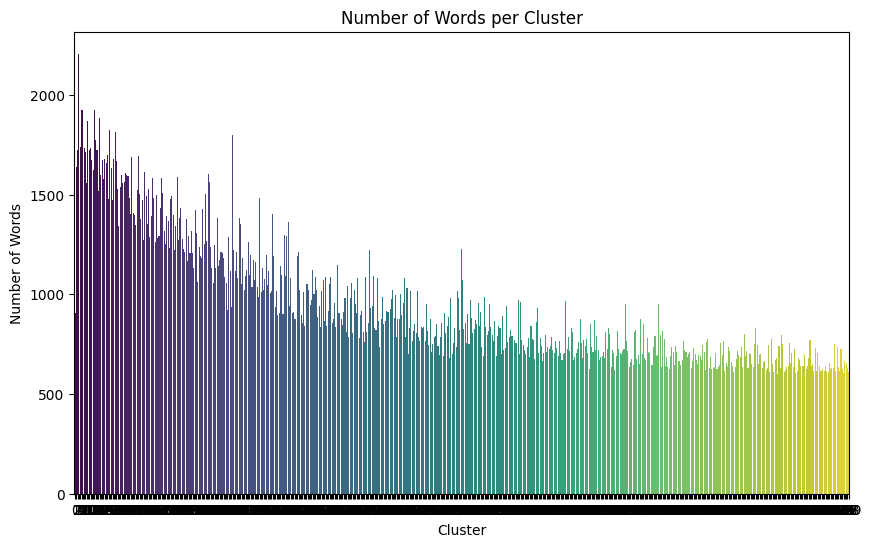

2024-09-16 05:10:54,660 - INFO - Calculating silhouette score...
2024-09-16 05:10:55,014 - INFO - Silhouette Score: -0.448
2024-09-16 05:10:55,015 - INFO - Plotting silhouette scores for each cluster...
Clusters processed: 100%|██████████| 600/600 [00:00<00:00, 1127.41it/s]


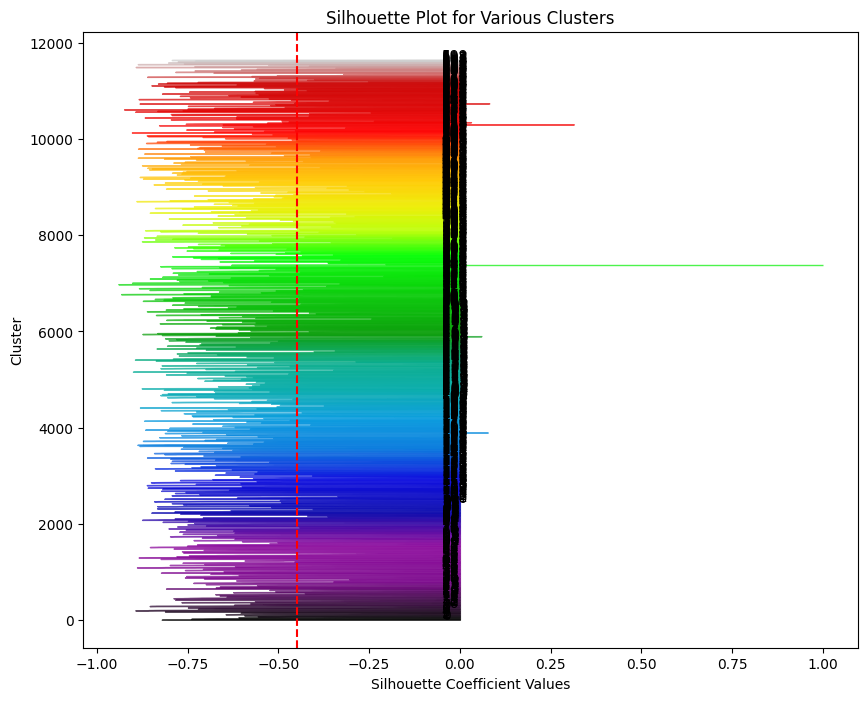

In [52]:
plot_cluster_word_counts(cluster_indices)
# plot_cluster_centers_pca(noun_vectors, kmeans, cluster_indices)
plot_silhouette_analysis(noun_vectors, cluster_indices, num_clusters)

In [53]:
import MeCab
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def preprocess_and_cluster(noun_vectors, num_clusters):
    """
    データの前処理（標準化、次元削減）を行い、K-meansクラスタリングを実行する。
    """
    # データの標準化
    scaler = StandardScaler()
    scaled_vectors = scaler.fit_transform(noun_vectors)

    # 次元削減（例: PCAで2次元に削減）
    pca = PCA(n_components=5)  # 次元削減後の次元数を設定
    reduced_vectors = pca.fit_transform(scaled_vectors)

    # K-meansクラスタリングの実行
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(reduced_vectors)

    return kmeans, reduced_vectors

def process_noun_batch(model, nouns, num_clusters):
    """
    バッチ内の名詞に対してクラスタリングを実行し、結果を返す。
    """
    # 名詞のベクトルを取得
    noun_vectors = np.array([model[word] for word in nouns])

    if noun_vectors.size == 0:
        print("名詞ベクトルが空です。")
        return None, None, None, {}

    # K-meansクラスタリングの実行
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(noun_vectors)

    # 各名詞が属するクラスタを取得
    cluster_indices = kmeans.labels_

    # 名詞とクラスタの対応を取得
    noun_cluster_map = {noun: cluster_indices[i] for i, noun in enumerate(nouns)}

    # 結果を表示 (例: 最初の10名詞)
    for noun, cluster in list(noun_cluster_map.items())[:10]:
        print(f"Noun: {noun}, Cluster: {cluster}")

    return noun_vectors, kmeans, cluster_indices, noun_cluster_map


def kmeans_cluster_nouns_with_preprocessing(model_path, num_clusters, batch_size):
    """
    名詞をバッチごとに処理し、前処理を行った後にK-meansクラスタリングを実行する。
    """
    # Word2Vecモデルの読み込み
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # MeCabの初期化
    mecab = MeCab.Tagger('-r /opt/homebrew/etc/mecabrc -d /opt/homebrew/lib/mecab/dic/ipadic')

    # 名詞を格納するリスト
    nouns = []

    # バッチごとの結果を格納するリスト
    all_noun_vectors = []
    all_cluster_indices = []
    all_noun_cluster_map = {}  # クラスタごとの名詞を格納するマップ

    # モデル内の単語を1つずつ解析
    for idx, word in enumerate(model.index_to_key):
        parsed = mecab.parse(word)
        for line in parsed.splitlines():
            if line == 'EOS':  # MeCabの解析終了マーク
                break
            fields = line.split('\t')
            if len(fields) > 1:
                pos_info = fields[1].split(',')  # 品詞情報を取得
                if pos_info[0] == '名詞' and pos_info[1] == '一般':  # 一般名詞の条件を追加
                    nouns.append(word)
                    break

        # バッチサイズに到達したら処理
        if len(nouns) >= batch_size:
            print(f"Processing batch {idx // batch_size + 1}...")  # バッチ進行状況の表示
            noun_vectors, kmeans, cluster_indices, noun_cluster_map = process_noun_batch(model, nouns, num_clusters)
            if noun_vectors is not None:
                all_noun_vectors.append(noun_vectors)
                all_cluster_indices.append(cluster_indices)
                for noun, cluster in noun_cluster_map.items():
                    if cluster not in all_noun_cluster_map:
                        all_noun_cluster_map[cluster] = []
                    all_noun_cluster_map[cluster].append(noun)
            nouns.clear()  # 次のバッチのためにリストをクリア

    # 最後に残った名詞を処理（バッチに満たない場合）
    if nouns:
        print("Processing final batch...")
        noun_vectors, kmeans, cluster_indices, noun_cluster_map = process_noun_batch(model, nouns, num_clusters)
        if noun_vectors is not None:
            all_noun_vectors.append(noun_vectors)
            all_cluster_indices.append(cluster_indices)
            for noun, cluster in noun_cluster_map.items():
                if cluster not in all_noun_cluster_map:
                    all_noun_cluster_map[cluster] = []
                all_noun_cluster_map[cluster].append(noun)

    # 結果を連結して最終結果とする
    if all_noun_vectors:
        all_noun_vectors = np.vstack(all_noun_vectors)
        all_cluster_indices = np.concatenate(all_cluster_indices)
        print(f"Total vectors: {all_noun_vectors.shape}")

        # データの前処理とクラスタリング
        kmeans, reduced_vectors = preprocess_and_cluster(all_noun_vectors, num_clusters)

        # クラスタごとのサンプリングと表示
        print("----- クラスタごとのサンプリング結果 -----")
        for cluster, nouns_in_cluster in all_noun_cluster_map.items():
            print(f"\nCluster {cluster}:")
            sampled_nouns = random.sample(nouns_in_cluster, min(100, len(nouns_in_cluster)))  # 最大100個をサンプリング
            for noun in sampled_nouns:
                print(f"  {noun}")

    else:
        all_noun_vectors = None

    return all_noun_vectors, kmeans, all_cluster_indices

In [54]:

model_path = '../data/japanese_word2vec_vectors.vec'  # モデルのパスを指定
num_clusters = 10  # クラスタ数を指定
batch_size = 1000  # バッチサイズを指定

noun_vectors, kmeans, cluster_indices = kmeans_cluster_nouns_with_preprocessing(model_path, num_clusters, batch_size)

2024-09-16 18:24:54,302 - INFO - loading projection weights from ../data/japanese_word2vec_vectors.vec
2024-09-16 18:27:01,699 - INFO - KeyedVectors lifecycle event {'msg': 'loaded (1015474, 200) matrix of type float32 from ../data/japanese_word2vec_vectors.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-09-16T18:27:01.699412', 'gensim': '4.3.3', 'python': '3.9.6 (default, Mar 29 2024, 10:51:09) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


Processing batch 3...
Noun: もの, Cluster: 2
Noun: 中, Cluster: 3
Noun: 者, Cluster: 2
Noun: 時, Cluster: 3
Noun: 名, Cluster: 3
Noun: ば, Cluster: 2
Noun: 間, Cluster: 3
Noun: 上, Cluster: 3
Noun: 内, Cluster: 3
Noun: 他, Cluster: 3
Processing batch 5...
Noun: 南西, Cluster: 8
Noun: [鉄道], Cluster: 8
Noun: 墓, Cluster: 2
Noun: 隣, Cluster: 8
Noun: ざる, Cluster: 4
Noun: 中央部, Cluster: 8
Noun: 質, Cluster: 1
Noun: 信号, Cluster: 3
Noun: 同時, Cluster: 1
Noun: 政治的, Cluster: 4
Processing batch 8...
Noun: [文化_(元号)], Cluster: 3
Noun: [東日本大震災], Cluster: 9
Noun: 責任者, Cluster: 6
Noun: フィート, Cluster: 7
Noun: 濃度, Cluster: 7
Noun: 背後, Cluster: 0
Noun: 職務, Cluster: 2
Noun: 山地, Cluster: 8
Noun: [競馬の競走], Cluster: 1
Noun: 電源, Cluster: 4
Processing batch 10...
Noun: 負, Cluster: 8
Noun: [6月1日], Cluster: 7
Noun: ラン, Cluster: 1
Noun: 平坦, Cluster: 0
Noun: ラスト, Cluster: 1
Noun: 荷物, Cluster: 8
Noun: 痕跡, Cluster: 8
Noun: レッド, Cluster: 6
Noun: [千葉ロッテマリーンズ], Cluster: 1
Noun: 繋がり, Cluster: 4
Processing batch 12...
Noun: 優, Cluster: 9

In [4]:
# plot_cluster_word_counts(cluster_indices)
# plot_cluster_centers_pca(noun_vectors, kmeans, cluster_indices)
# plot_silhouette_analysis(noun_vectors, cluster_indices, num_clusters)